# SDR Based Antenna / Filter Analyzer

This is version 3.0 of the Antenna Analyzer. It is quite slow as it tunes to a centre frequency, takes a sample and moves up the sweep 1MHz at a time, calculating the VSWR at each step.

### Source: https://git.scriptforge.org/arden/sdr-antenna-analyzer

We connect the equipment like this:

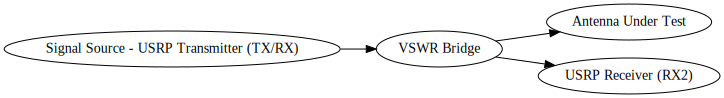

In [1]:
# Use the graphviz library to make a nice node graph
from graphviz import Digraph
hw_setup = Digraph(comment='Hardware Setup')
hw_setup.attr(rankdir='LR')
hw_setup.node('A', 'Signal Source - USRP Transmitter (TX/RX)')
hw_setup.node('B', 'VSWR Bridge')
hw_setup.node('D', 'Antenna Under Test')
hw_setup.node('C', 'USRP Receiver (RX2)')
hw_setup.edges(['AB', 'BD', 'BC'])
hw_setup

In [2]:
# Import GNURadio blocks to create our app
from gnuradio import gr
from gnuradio import blocks
from gnuradio import analog
from gnuradio import uhd
from gnuradio import fft
from gnuradio import iio    # provided by Ubuntu package gr-iio

## Hierarchical Block - Constant Vector Float

The flowgraph uses float vectors after the FFT stage, and performing math operations you can't just do an 'Add Const' as the const needs to be a vector as well, eg so to add const 1, you would need to provide the constant variable as 1, 1, 1, 1, ... (to the size of the vector).

To get around this I made a hierarchical block to reduce the copy/pasting of simple constant blocks:

![constant vector float flowgraph](constant_vector_f_screenshot.png)

In [3]:
import os
import sys
sys.path.append(os.environ.get('GRC_HIER_PATH', os.path.expanduser('~/.grc_gnuradio')))
from constant_vector_f import constant_vector_f  # grc-generated hier_block

In [4]:
# Python libraries for working with data frames and plotting
from datetime import datetime
import numpy
import time
import pandas
import scipy
from scipy import signal
import ipywidgets as widgets
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: 1000px;
}
.output_scroll {
    box-shadow:none !important
    webkit-box-shadow:none !important;
}
</style>

In [6]:
# Set some variables for start
sample_rate = 1e6
freq = 400e6
input_gain_db = 44
noise_gain_db = 44
fft_size = 256

In [7]:
# Set up the receiver
receiver = uhd.usrp_source(",".join(("", "")), 
                        uhd.stream_args(cpu_format="fc32",channels=range(1)))
receiver.set_gain(input_gain_db, 0)
receiver.set_antenna('RX2', 0)
receiver.set_samp_rate(sample_rate)
receiver.set_center_freq(freq)

<gnuradio.uhd.uhd_swig.tune_result_t; proxy of <Swig Object of type 'uhd::tune_result_t *' at 0x7f1731130510> >

In [8]:
# Set up the Transmitter
transmitter = uhd.usrp_sink(",".join(("", "")), uhd.stream_args(cpu_format="fc32",	channels=range(1),),)
transmitter.set_samp_rate(sample_rate)
transmitter.set_gain(noise_gain_db, 0)
transmitter.set_antenna('TX/RX', 0)
transmitter.set_center_freq(freq)

<gnuradio.uhd.uhd_swig.tune_result_t; proxy of <Swig Object of type 'uhd::tune_result_t *' at 0x7f1731177fc0> >

## VSWR Calculation

We start with the input signal and the reflected signal. This will give a ratio between 0 to 1 for the size of the reflected signal

\begin{equation*}
R_{level} = \frac{P_{reflected}}{P_{in}}
\end{equation*}

We are dealing with a signal (voltage level) so we will use $20 \log_{10} P_{signal}$ so we can just subtract the two logs.

We also use a complex_mag_squared block instead of complex_mag so we don't need to do the intensive square root function, and so instead we use $10 \log_{10} P_{signal}$

To get s11 or the reflection coefficient $\mid\rho\mid$
\begin{equation*}
R_{level} = 20 \log_{10} \mid\rho\mid
\\
\mid\rho\mid = 10^{R_{level}/20}
\end{equation*}

Finally the VSWR is
\begin{equation*}
VSWR = \frac{1 + \mid\rho\mid}{1 - \mid\rho\mid}
\end{equation*}

## Flowgraph

These are the equivalent of the graphical flow graphs that GNURadio Companion makes. The Python code in the next cell generates a flowgraph similar to that found in this GNURadio Companion screenshot.

![VSWR Analyzer](analyzer3_vswr_ctr_freq_simple_screenshot.png)

In [9]:
# Create a flow graph with all the bits to send the signal source as well as receive it
# Signal is just a sine wave in this case as we are only sampling the centre frequency

flowgraph = gr.top_block()

# Take the received signal and put it through an FFT
sig_source = analog.sig_source_c(sample_rate, analog.GR_SIN_WAVE, 1000, 1, 0)
s2v_rx = blocks.stream_to_vector(gr.sizeof_gr_complex*1, fft_size)
fft_vec_rx = fft.fft_vcc(fft_size, True, (), True, 1)
cm2_rx = blocks.complex_to_mag_squared(fft_size)
log10_rx = blocks.nlog10_ff(10, fft_size)

# Take the source signal and put it through an FFT
s2v_tx = blocks.stream_to_vector(gr.sizeof_gr_complex*1, fft_size)
fft_vec_tx = fft.fft_vcc(fft_size, True, (), True, 1)
cm2_tx = blocks.complex_to_mag_squared(fft_size)
log10_tx = blocks.nlog10_ff(10, fft_size)

# Constants to add, multiply and divide with
cvf_20 = constant_vector_f(vector_size=fft_size, constant=20)
cvf_10 = constant_vector_f(vector_size=fft_size, constant=10)
cvf_1_num = constant_vector_f(vector_size=fft_size, constant=1)
cvf_1_denom = constant_vector_f(vector_size=fft_size, constant=1)
cvf_neg1 = constant_vector_f(vector_size=fft_size, constant=-1)

# Blocks to perform vector math operations
sub_refl_power_pc = blocks.sub_ff(fft_size)
div_refl_20 = blocks.divide_ff(fft_size)
mul_negate_s11 = blocks.multiply_ff(fft_size)
add_vswr_numerator = blocks.add_ff(fft_size)
add_vswr_denominator = blocks.add_ff(fft_size)
ten_to_exp = iio.power_ff(fft_size)
div_vswr = blocks.divide_ff(fft_size)

# Probe to sample the s11
probe_s11 = blocks.probe_signal_vf(fft_size)
# Probe to sample the VSWR
probe_vswr = blocks.probe_signal_vf(fft_size)

# Connect the source to transmitter and the FFT blocks
flowgraph.connect((sig_source, 0), (transmitter, 0))
flowgraph.connect((sig_source, 0), (s2v_tx, 0))
flowgraph.connect((s2v_tx, 0), (fft_vec_tx, 0))
flowgraph.connect((fft_vec_tx, 0), (cm2_tx, 0))
flowgraph.connect((cm2_tx, 0), (log10_tx, 0))

# Connect the receiver to the FFT blocks
flowgraph.connect((receiver, 0), (s2v_rx, 0))
flowgraph.connect((s2v_rx, 0), (fft_vec_rx, 0))
flowgraph.connect((fft_vec_rx, 0), (cm2_rx, 0))
flowgraph.connect((cm2_rx, 0), (log10_rx, 0))

# Subtract tx and rx signals
flowgraph.connect((log10_tx, 0), (sub_refl_power_pc, 1))
flowgraph.connect((log10_rx, 0), (sub_refl_power_pc, 0))

# Divide reflected power percent signal by 20
flowgraph.connect((sub_refl_power_pc, 0), (div_refl_20, 0))
flowgraph.connect((cvf_20, 0), (div_refl_20, 1))

# 10 to the power of previous division operation will produce s11
flowgraph.connect((cvf_10, 0), (ten_to_exp, 0))
flowgraph.connect((div_refl_20, 0), (ten_to_exp, 1))
flowgraph.connect((ten_to_exp, 0), (probe_s11, 0))  # Probe connected here

# Prepare the numerator for the VSWR calculation
flowgraph.connect((cvf_1_num, 0), (add_vswr_numerator, 0))
flowgraph.connect((ten_to_exp, 0), (add_vswr_numerator, 1))

# Prepare the denominator for the VSWR calculation
flowgraph.connect((cvf_neg1, 0), (mul_negate_s11, 0))
flowgraph.connect((ten_to_exp, 0), (mul_negate_s11, 1))
flowgraph.connect((cvf_1_denom, 0), (add_vswr_denominator, 0))
flowgraph.connect((mul_negate_s11, 0), (add_vswr_denominator, 1))

# Divide operation for VSWR
flowgraph.connect((add_vswr_numerator, 0), (div_vswr, 0))
flowgraph.connect((add_vswr_denominator, 0), (div_vswr, 1))
flowgraph.connect((div_vswr, 0), (probe_vswr, 0)) # Probe connected here

flowgraph.start()
calibration_df = None
return_signal = None

In [10]:
def get_vswr_sweep(start_freq, stop_freq, step_freq=sample_rate, step_time=0.1, nbwidgets=None):
    '''
    Run through the frequency range and collect the levels
    '''
    freq = start_freq
    start_time = datetime.now()
    nbwidgets['status'].value = "Starting sweep from %.3fMHz to %.3fMHz in steps of %.0fMHz" % (start_freq/1e6, 
                                                                          stop_freq/1e6, 
                                                                          step_freq/1e6)
    df_return = pandas.DataFrame(columns=['Return Signal'])
    nbwidgets['progress'].value = 0
    while freq < stop_freq:
        transmitter.set_center_freq(freq)
        receiver.set_center_freq(freq)
        time.sleep(step_time)
        fft_vswr = probe_vswr.level()
        fft_s11 = probe_s11.level()   # not used right now
        ctr_freq_level = fft_vswr[fft_size/2]
        return_df = pandas.DataFrame([ctr_freq_level], index=[freq/1e6], columns=['Return Signal'])
        df_return = df_return.append(return_df)
        nbwidgets['progress'].value = int(((freq - start_freq)/(stop_freq-start_freq))*100)
        freq += step_freq
    end_time = datetime.now()
    nbwidgets['progress'].value = 100
    nbwidgets['status'].value = "Finished in %d seconds" % (end_time - start_time).seconds
    return df_return

In [11]:
def show_return_plot(df, out):
    '''
    Takes a Pandas DF with the return signal from the sweep and puts it in a graph
    '''
    dfsource = ColumnDataSource(df)

    return_plot = figure(title="VSWR",
                         width=900,
                         x_axis_label='Frequency', 
                         y_axis_label='VSWR',
                         y_axis_type='log')
    return_plot.circle(x='index', y='Return Signal', source=dfsource, color='red')
    return_plot.line(x='index', y='Smoothed Return', source=dfsource, color='blue', line_width=3)
    with out:
        show(return_plot)

In [12]:
# Set up the widgets to control the scan
def start_scan(b):
    ''' Respond to button click event '''
    try:
        global return_signal
        fr = nbw['freq_range'].value
        fstart = fr[0] * 1e6
        fstop = fr[1] * 1e6
        fs = nbw['freq_step'].value * 1e6
        st = nbw['sample_time'].value
        return_signal = get_vswr_sweep(fstart, fstop, step_freq=fs, step_time=st, nbwidgets=nbw)
        return_signal['Smoothed Return'] = signal.savgol_filter(return_signal['Return Signal'], 53, 3)
        show_return_plot(return_signal, nbw['out'])
    except Exception as err:
        with out:
            print(type(err))
            print(err)

nbw = {}
out = nbw['out'] = widgets.Output()
nbw['progress'] = widgets.FloatProgress(min=0, max=100, value=0)
nbw['freq_range']= widgets.IntRangeSlider(min=70, max=3000, value=[300, 1400], step=1)
nbw['freq_step'] = widgets.BoundedIntText(value=1, min=1, max=10, step=1)
nbw['sample_time'] = widgets.BoundedFloatText(value=0.1, min=0, max=1.5, step=0.1)
nbw['status'] = widgets.HTML(value="Waiting to scan")
nbw['start_scan'] = widgets.Button(description='Start Scan', button_style='info')
nbw['start_scan'].on_click(start_scan)
display(widgets.VBox([
    widgets.HBox([widgets.Label('Scan Progress', layout={'min_width': '150px'}), nbw['progress']]),
    widgets.HBox([widgets.Label('Status', layout={'min_width': '150px'}), nbw['status']]),
    widgets.HBox([widgets.Label('Frequency Range', layout={'min_width': '150px'}), nbw['freq_range']]),
    widgets.HBox([widgets.Label('Frequency Step', layout={'min_width': '150px'}), nbw['freq_step']]),
    widgets.HBox([widgets.Label('Sample Time', layout={'min_width': '150px'}), nbw['sample_time']]),
    widgets.HBox([nbw['start_scan']]),
    nbw['out']]))

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oTGFiZWwodmFsdWU9dSdTY2FuIFByb2dyZXNzJywgbGF5b3V0PUxheW91dChtaW5fd2lkdGg9dScxNTBweCcpKSwgRmxvYXRQcm9ncmVzcyjigKY=
